In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from fab.utils.logging import ListLogger
from fab.target_distributions.gmm import GMM
from fab.utils.prioritised_replay_buffer import SimpleBuffer
from torch.autograd import grad
from tqdm import tqdm


from typing import Union
import numpy as np
import matplotlib.pyplot as plt
import torch

from typing import Tuple, Optional
import torch
from functorch import vmap


from functools import partial


import torchsde
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable

from math import sqrt


from torchdiffeq import odeint
from torch.func import jacrev

from src.utils.data_utils import remove_mean
from src.models.components.egnn import EGNN_dynamics

from bgflow import Energy
from bgflow.utils import distance_vectors, distances_from_vectors

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Target Distribution

In [8]:
from src.energies.lennardjones_energy import LennardJonesEnergy

target = LennardJonesEnergy(
    dimensionality=39,
    n_particles=13,
    device=device,
    data_path="../../data/all_data_LJ13-2.npy",
)

### Helper Functions

In [9]:
from src.models.components.noise_schedules import QuadraticNoiseSchedule

In [10]:
def clip(f, max_norm):
    norm = torch.linalg.vector_norm(f, dim=-1)
    clip_coef = torch.clamp(max_norm / (norm + 1e-6), max=1)
    f = f * clip_coef.unsqueeze(-1)
    return f

In [11]:
def sample_from_array(array, size):
    idx = np.random.choice(array.shape[0], size=size)
    return array[idx]

## Function Definitions

### Estimated Reward Functions

In [12]:
# calculate the log expectation of the reward
def log_E_R(_x, _t, noise_schedule, num_mc_samples, var_exploding=True):
    repeated_x = _x.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    repeated_t = _t.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    h_t = noise_schedule.h(repeated_t)
    h_t = h_t.unsqueeze(1)
    if var_exploding:
        # variance exploding
        samples = repeated_x + torch.randn(repeated_x.shape).to(device) * (h_t**0.5)
        log_rewards = target(samples).squeeze()
        log_expectation_R = torch.logsumexp(log_rewards, dim=-1) - np.log(
            num_mc_samples
        )
    else:
        # variance preserving
        samples = repeated_x / torch.sqrt(1 - repeated_t.unsqueeze(1)) + torch.randn(
            repeated_x.shape
        ).to(device) * (h_t**0.5)
        log_rewards = target._log_prob(samples).squeeze()
        log_expectation_R = (
            torch.log(1 / (1 - _t))
            + torch.logsumexp(log_rewards, dim=-1)
            - np.log(num_mc_samples)
        )
    return log_expectation_R

In [13]:
def estimated_Rt(x, t, beta, num_mc_samples=100, var_exploding=True):
    if t.dim() == 0:
        # repeat the same time for all points if we have a scalar time
        t = t * torch.ones(x.shape[0]).to(device)
    return torch.vmap(log_E_R, randomness="different", in_dims=(0, 0, None, None))(
        x, t, beta, num_mc_samples, var_exploding=var_exploding
    )

In [14]:
def estimate_grad_Rt(
    x, t, noise_schedule, num_mc_samples=100, var_exploding=True, richardson=False
):
    est_scores_n = torch.func.grad(log_E_R)(
        x, t, noise_schedule, num_mc_samples, var_exploding=var_exploding
    )
    if richardson:
        est_scores_n_div2 = torch.func.grad(log_E_R)(
            x, t, noise_schedule, num_mc_samples // 2, var_exploding=var_exploding
        )
        return 2 * est_scores_n - est_scores_n_div2
    else:
        return est_scores_n

## SDE

### Dataset

In [11]:
n_nodes = 13
dim = 3

In [12]:
samples_all = np.load("../../data/all_data_LJ13-2.npy")
test_data = samples_all[len(samples_all) // 2 :]
# test_data = sample_from_array(test_data, 1000)
del samples_all

test_data = remove_mean(test_data, n_particles=n_nodes, n_dimensions=dim)
test_data = torch.tensor(test_data, device=device)

In [13]:
# dist_test = target.interatomic_dist(test_data)
# plt.hist(dist_test.view(-1).cpu(), bins=100, label="holdout samples", alpha=0.5, density=True, histtype='step', linewidth=4)
# plt.show()

### VE SDE

In [14]:
from src.models.components.sdes import VEReverseSDE
from src.models.components.sde_integration import integrate_sde

In [15]:
# class VEReverseSDE(torch.nn.Module):

#     def __init__(self, score, noise_schedule):
#         super().__init__()
#         self.score = score
#         self.noise_schedule = noise_schedule

#     def f(self, t, x):
#         if t.dim() == 0:
#             # repeat the same time for all points if we have a scalar time
#             t = t * torch.ones(x.shape[0]).to(device)

#         x.requires_grad = True
#         score = self.score(t, x)
#         norm = torch.linalg.vector_norm(score, dim=-1)
#         max_norm = 200
#         clip_coef = torch.clamp(max_norm / (norm+1e-6), max=1)
#         return self.g(t, x)**2 * score * clip_coef[:,None]

#     def g(self, t, x):
#         g = self.noise_schedule.g(t)
#         return g.unsqueeze(1) if g.ndim > 0 else torch.full_like(x, g)

In [16]:
def generate_samples(reverse_sde, num_samples, return_full_trajectory):
    samples = prior.sample(num_samples)

    return integrate(
        reverse_sde=reverse_sde,
        samples=samples,
        return_full_trajectory=return_full_trajectory,
    )


def integrate(reverse_sde, samples, return_full_trajectory=False):
    trajectory = integrate_sde(
        reverse_sde,
        samples,
        1000 + 1,
        reverse_time=True,
    )
    if return_full_trajectory:
        return trajectory
    return trajectory[-1]

### SDE Tests

In [43]:
class VEReverseSDE(torch.nn.Module):
    noise_type = "diagonal"
    sde_type = "ito"

    def __init__(self, score, noise_schedule):
        super().__init__()
        self.score = score
        self.noise_schedule = noise_schedule

    def f(self, t, x):
        if t.dim() == 0:
            # repeat the same time for all points if we have a scalar time
            t = t * torch.ones(x.shape[0]).to(device)

        x.requires_grad = True
        score = torch.vmap(self.score, randomness="different", in_dims=(0, 0, None))(
            x, 1 - t, self.noise_schedule
        )
        norm = torch.linalg.vector_norm(score, dim=-1)
        max_norm = 50
        clip_coef = torch.clamp(max_norm / (norm + 1e-6), max=1)
        return self.g(t) ** 2 * score * clip_coef[:, None]

    def g(self, t):
        return self.noise_schedule.g(t.unsqueeze(1))

In [44]:
def euler_maruyama_step(sde, x, t, dt):
    # Calculate drift and diffusion terms
    if t.dim() == 0:
        # repeat the same time for all points if we have a scalar time
        t = t * torch.ones(x.shape[0]).to(device)

    drift = sde.f(t, x) * dt
    diffusion = sde.g(t) * np.sqrt(dt) * torch.randn_like(x).to(device)

    # Update the state
    x_next = x + drift + diffusion
    return x_next, drift


def integrate_sde(sde, x0, t_span, dt):
    times = torch.arange(t_span[0], t_span[1], dt).to(device)
    x = x0
    x0.requires_grad = True
    vectors = []
    samples = []
    with torch.no_grad():
        for t in times:
            x, f = euler_maruyama_step(sde, x, t, dt)
            samples.append(x)
            vectors.append(f)
    return torch.stack(samples)

In [45]:
ve_reverse_sde = VEReverseSDE(estimate_grad_Rt, noise_schedule)
samples_pred = integrate_sde(ve_reverse_sde, x1_samples, [0, 1], 1e-3)

In [46]:
# save samples_pred
np.save("samples_pred_2.npy", samples_pred.detach().cpu().numpy())

In [ ]:
samples_energy = target(samples_pred[-1])
test_data_energy = target(test_data)

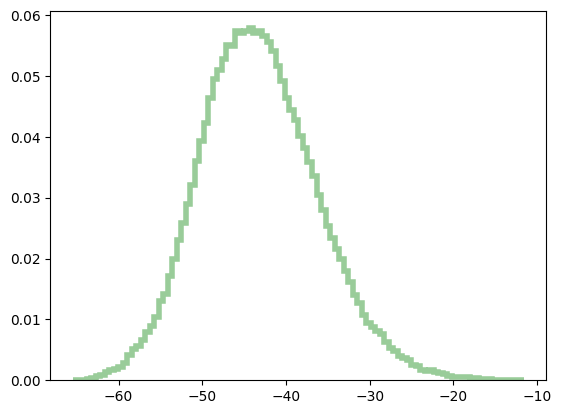

In [ ]:
plt.hist(
    -test_data_energy.detach().cpu(),
    bins=100,
    density=True,
    alpha=0.4,
    color="g",
    histtype="step",
    linewidth=4,
    label="test data",
);

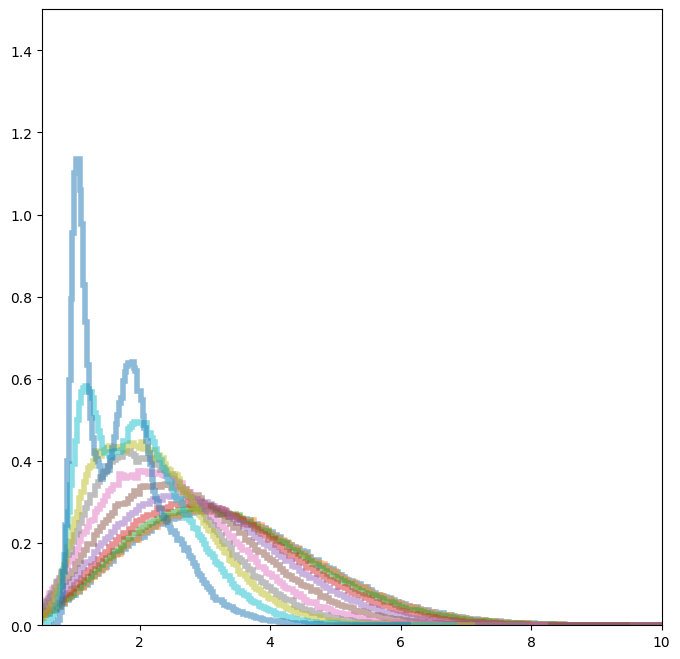

In [47]:
fig = plt.figure(figsize=(8, 8))
for i in range(0, 1000, 99):
    pred_dists = target.interatomic_dist(samples_pred[i]).detach()
    plt.hist(
        pred_dists.view(-1).cpu().numpy(),
        bins=200,
        alpha=0.5,
        density=True,
        histtype="step",
        linewidth=4,
    )
plt.xlim(0.5, 10)
plt.ylim(0, 1.5)
plt.show()

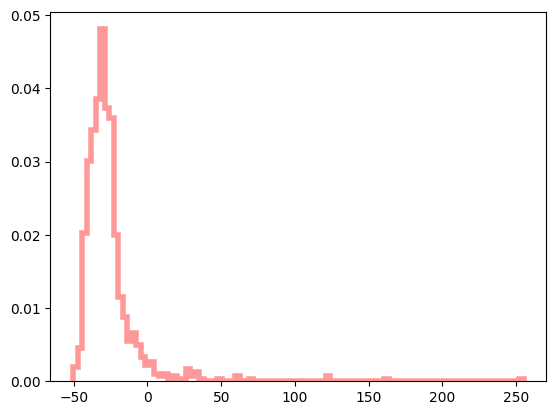

In [ ]:
plt.hist(
    -samples_energy.detach().cpu(),
    bins=100,
    density=True,
    alpha=0.4,
    color="r",
    histtype="step",
    linewidth=4,
    label="generated data",
);

In [ ]:
plt.hist(
    -test_data_energy.detach().cpu(),
    bins=100,
    density=True,
    alpha=0.4,
    range=(-60, 0),
    color="g",
    histtype="step",
    linewidth=4,
    label="test data",
)

plt.hist(
    -samples_energy.detach().cpu(),
    bins=100,
    density=True,
    alpha=0.4,
    range=(-60, 0),
    color="r",
    histtype="step",
    linewidth=4,
    label="generated data",
)
plt.xlabel("Energy")
plt.legend()
plt.show()

## Training

### Dataset

In [56]:
train_data = np.concatenate(
    (np.load("samples_pred_1.npy")[-1], np.load("samples_pred_2.npy")[-1]), axis=0
)
train_data = torch.tensor(train_data, device=device)

In [15]:
sigma = np.sqrt(1)
beta = torch.tensor(sigma**2)
dim = 3
n_nodes = 13
n_samples = 5000  # 512

noise_schedule = QuadraticNoiseSchedule(beta, norm_factor=1.0)

In [16]:
from src.energies.base_prior import MeanFreePrior

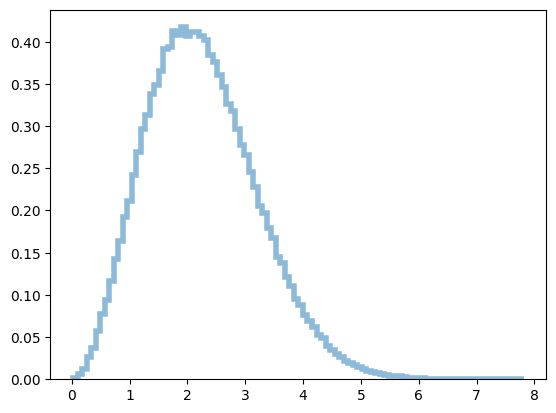

In [17]:
prior = MeanFreePrior(13, 3, 1, device=device)
x1_samples = prior.sample(n_samples).to(device)
x1_energy = prior.log_prob(x1_samples)

x1_dists = target.interatomic_dist(x1_samples)
plt.hist(
    x1_dists.view(-1).cpu().numpy(),
    bins=100,
    alpha=0.5,
    density=True,
    histtype="step",
    linewidth=4,
)
plt.show()

### Model

### Training

In [63]:
samples_all = np.load("../../data/all_data_LJ13-2.npy")
test_data = samples_all[len(samples_all) // 2 :]


# train_data = samples_all[:len(samples_all)//2]

test_data = sample_from_array(test_data, 1000)
del samples_all

test_data = remove_mean(test_data, n_particles=n_nodes, n_dimensions=dim)
test_data = torch.tensor(test_data, device=device)
test_dists = target.interatomic_dist(test_data)

# train_data = remove_mean(train_data, n_particles=n_nodes, n_dimensions=dim)
# train_data = torch.tensor(train_data, device=device)

In [45]:
# samples_all = np.load('../../data/all_data_LJ13.npy')
# test_data = samples_all[:1000] #samples_all[len(samples_all)//2:]


# samples_all = np.load('../../data/holdout_data_LJ13.npy')
# train_data = samples_all[:len(samples_all)//2]

# # test_data = sample_from_array(test_data, 1000)
# del samples_all

# test_data = remove_mean(test_data, n_particles=n_nodes, n_dimensions=dim)
# test_data = torch.tensor(test_data, device=device)
# test_dists = target.interatomic_dist(test_data)

# train_data = remove_mean(train_data, n_particles=n_nodes, n_dimensions=dim)
# train_data = torch.tensor(train_data, device=device)

In [64]:
def cfm_inference(model, xt, t, dt):
    with torch.no_grad():
        vt = model(t, xt)
        xt_new = xt + vt * dt
        return xt_new

In [65]:
def cfm_loss(model, x1):
    x1 = x1.reshape(-1, 13, 3)
    x0 = prior.sample(x1.shape[0]).to(device).reshape(-1, 13, 3)

    t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)

    xt = xt.reshape(-1, 39)
    ut = ut.reshape(-1, 39)

    vt = model(t, xt)
    loss = torch.mean((vt - ut) ** 2)
    return loss

In [66]:
def generate_samples_ode(model, x_init, t_span, dt):
    times = torch.arange(t_span[0], t_span[1], dt).to(device)
    samples = []
    x = x_init
    with torch.no_grad():
        for t in times:
            x = cfm_inference(model, x, t, dt)
            samples.append(x)
    return torch.stack(samples)

In [ ]:
x1_samples_cfm = prior.sample(5000).to(device)
samples = generate_samples_ode(model, x1_samples_cfm, [0, 1], 1e-3)[-1]

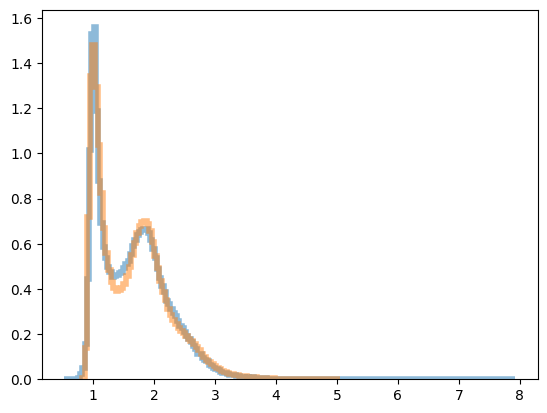

In [ ]:
dist_samples = target.interatomic_dist(samples)
test_dists = target.interatomic_dist(test_data)
plt.hist(
    dist_samples.view(-1).detach().cpu().numpy(),
    bins=200,
    alpha=0.5,
    density=True,
    histtype="step",
    linewidth=4,
    label="Samples",
)
plt.hist(
    test_dists.view(-1).detach().cpu().numpy(),
    bins=100,
    alpha=0.5,
    density=True,
    histtype="step",
    linewidth=4,
    label="True",
);

In [ ]:
test_data_energy = target(test_data)
samples_energy = target(samples)

In [ ]:
samples_energy.shape

torch.Size([5000])

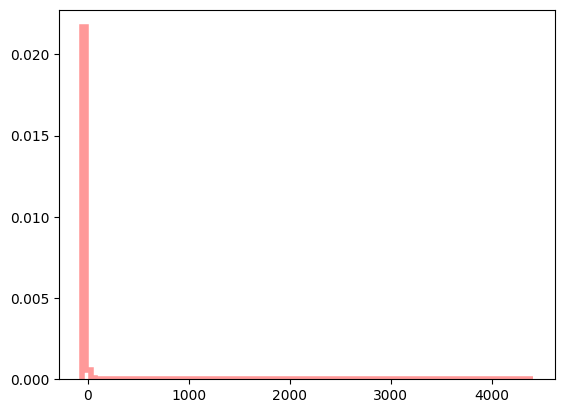

In [ ]:
plt.hist(
    -samples_energy.detach().cpu(),
    bins=100,
    density=True,
    alpha=0.4,
    color="r",
    histtype="step",
    linewidth=4,
    label="generated data",
);

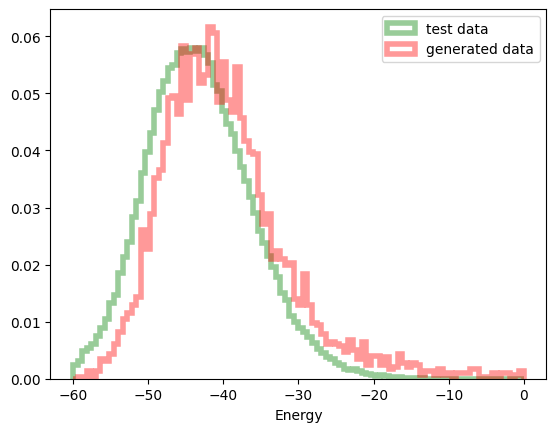

In [64]:
plt.hist(
    -test_data_energy.detach().cpu(),
    bins=100,
    density=True,
    alpha=0.4,
    range=(-60, 0),
    color="g",
    histtype="step",
    linewidth=4,
    label="test data",
)

plt.hist(
    -samples_energy.detach().cpu(),
    bins=100,
    density=True,
    alpha=0.4,
    range=(-60, 0),
    color="r",
    histtype="step",
    linewidth=4,
    label="generated data",
)
plt.xlabel("Energy")
plt.legend()
plt.show()

In [68]:
import sys

sys.path.append("../..")

In [69]:
from models.augmentation import AugmentedVectorField, CNFReg
from torchcfm.conditional_flow_matching import ConditionalFlowMatcher
from torchcfm.models.models import *
from torchcfm.utils import *
import torch
import torchdyn
from torchdyn.core import NeuralODE

In [70]:
FM = ConditionalFlowMatcher(sigma=0)

In [71]:
batch_size = 512
model = EGNN_dynamics(
    n_particles=n_nodes,
    n_dimension=dim,
    hidden_nf=32,
    act_fn=torch.nn.SiLU(),
    n_layers=3,
    recurrent=True,
    tanh=True,
    attention=True,
    condition_time=True,
    agg="sum",
).to(device)


amodel = AugmentedVectorField(model, [CNFReg("exact")], dim=(13, 3))
node = NeuralODE(amodel, solver="euler")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

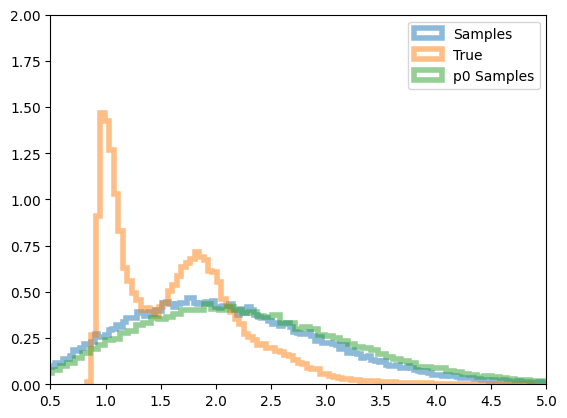

0 tensor(40.5934, device='cuda:0') tensor(42.4785, device='cuda:0')


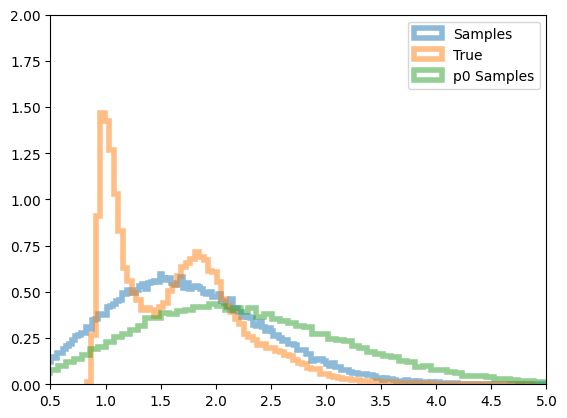

100 tensor(38.2202, device='cuda:0') tensor(40.7943, device='cuda:0')


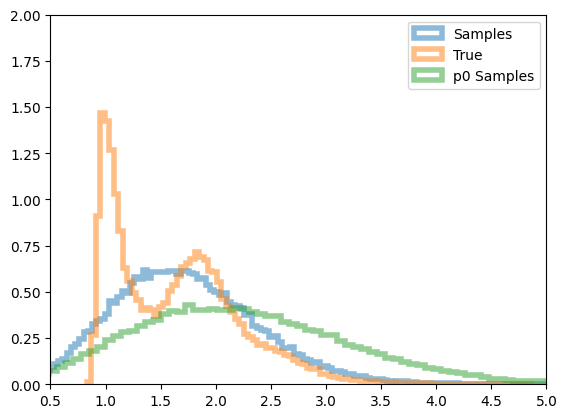

200 tensor(35.6566, device='cuda:0') tensor(38.6514, device='cuda:0')


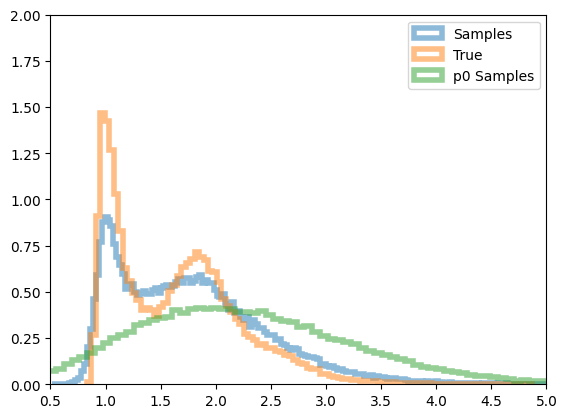

300 tensor(19.6674, device='cuda:0') tensor(29.6704, device='cuda:0')


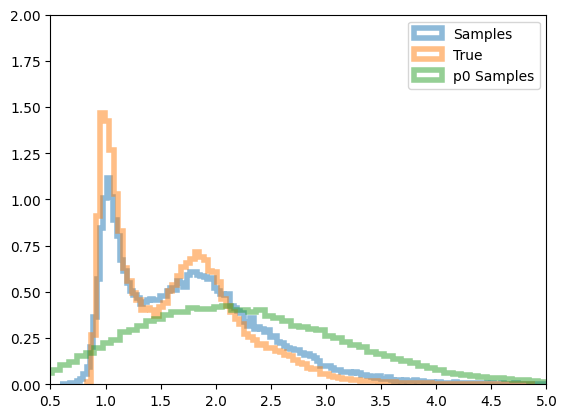

400 tensor(18.2918, device='cuda:0') tensor(28.3314, device='cuda:0')


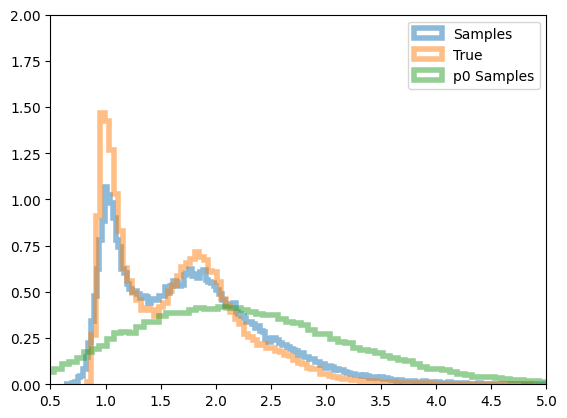

500 tensor(19.5603, device='cuda:0') tensor(27.1518, device='cuda:0')


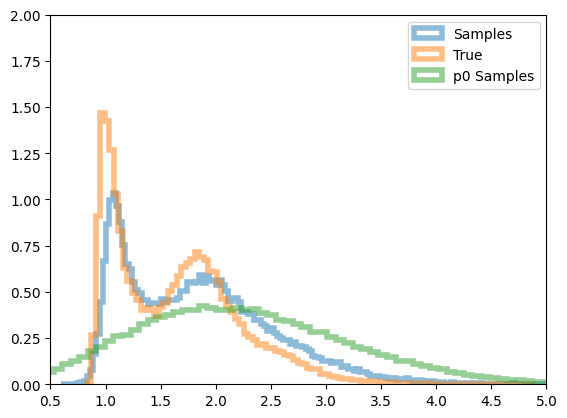

600 tensor(24.5005, device='cuda:0') tensor(31.1475, device='cuda:0')


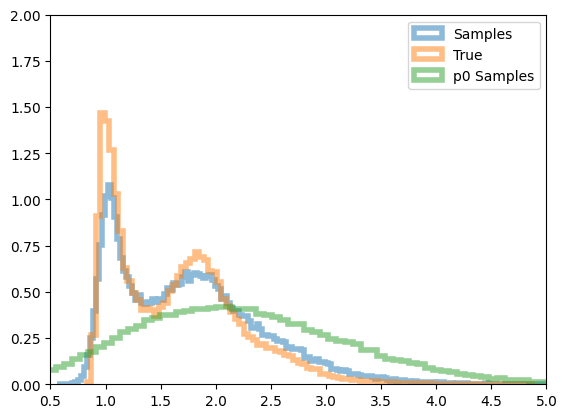

700 tensor(19.2115, device='cuda:0') tensor(26.9335, device='cuda:0')


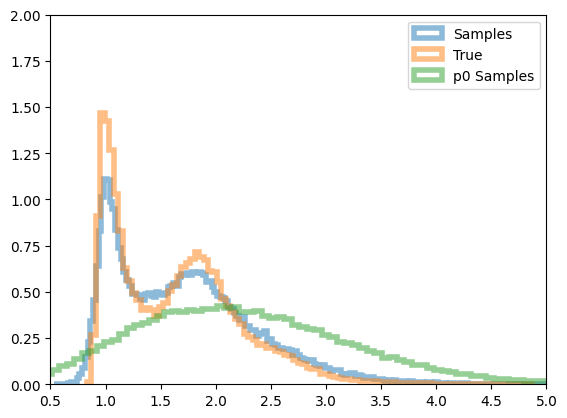

800 tensor(18.8614, device='cuda:0') tensor(27.3764, device='cuda:0')


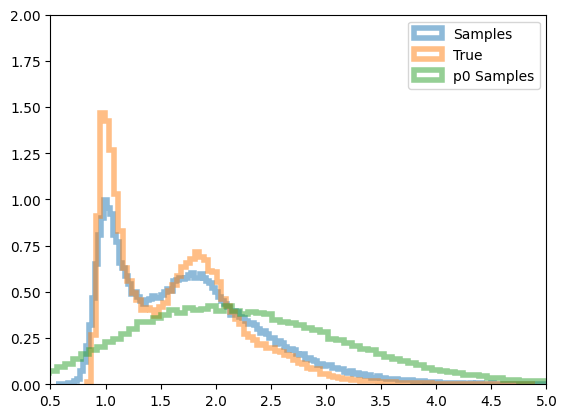

KeyboardInterrupt: 

In [72]:
for k in range(30000):
    optimizer.zero_grad()

    perm = torch.randperm(train_data.shape[0])
    idx = perm[:batch_size]
    x0 = train_data[idx].reshape(-1, 13, 3)

    loss = cfm_loss(model, x0)

    loss.backward()
    optimizer.step()

    if k % 100 == 0:
        x1_samples_cfm = prior.sample(1000).to(device)
        samples = generate_samples_ode(model, x1_samples_cfm, [0, 1], 1e-3)[-1]
        dist_samples = target.interatomic_dist(samples)
        dist_x1 = target.interatomic_dist(x1_samples_cfm)
        plt.hist(
            dist_samples.view(-1).detach().cpu().numpy(),
            bins=200,
            alpha=0.5,
            density=True,
            histtype="step",
            linewidth=4,
            label="Samples",
        )
        plt.hist(
            test_dists.view(-1).detach().cpu().numpy(),
            bins=100,
            alpha=0.5,
            density=True,
            histtype="step",
            linewidth=4,
            label="True",
        )
        plt.hist(
            dist_x1.view(-1).detach().cpu().numpy(),
            bins=100,
            alpha=0.5,
            density=True,
            histtype="step",
            linewidth=4,
            label="p0 Samples",
        )
        plt.xlim(0.5, 5)
        plt.ylim(0, 2)
        plt.legend()
        plt.show()

        with torch.no_grad():
            x0 = node.trajectory(
                torch.cat(
                    [
                        torch.zeros((100, 1)).to(device),
                        sample_from_array(test_data, 100),
                    ],
                    dim=-1,
                ),
                t_span=torch.linspace(1, 0, 101).to(device),
            )

            x0_centered = x0[-1, :, 1:]
            x0_centered = x0_centered.reshape(-1, 13, 3)
            x0_centered = x0_centered - x0_centered.mean(dim=-2, keepdims=True)

            nll = -(prior.log_prob(x0_centered) - x0[-1, :, 0])

            x0_train = node.trajectory(
                torch.cat(
                    [
                        torch.zeros((100, 1)).to(device),
                        sample_from_array(train_data, 100),
                    ],
                    dim=-1,
                ),
                t_span=torch.linspace(1, 0, 101).to(device),
            )
            x0_centered = x0_train[-1, :, 1:]
            x0_centered = x0_centered.reshape(-1, 13, 3)
            x0_centered = x0_centered - x0_centered.mean(dim=-2, keepdims=True)
            nll_train = -(prior.log_prob(x0_centered) - x0_train[-1, :, 0])
            print(k, nll.mean(), nll_train.mean())

In [ ]:
x1_samples = prior.sample(10000).reshape(-1, n_nodes * dim)
ve_reverse_sde = VEReverseSDE(vectorfield, noise_schedule)
samples = integrate_sde(ve_reverse_sde, x1_samples, [0, 1], 1e-3)[-1]


samples_energy = -target._log_prob(samples).detach().squeeze()
test_energy = -target._log_prob(test_data).detach().squeeze()

In [376]:
data_holdout.shape

torch.Size([500000, 39])

In [56]:
test_energy.shape

torch.Size([1000])

In [378]:
min_energy = min(test_energy.min(), samples_energy.min()).cpu().item()
max_energy = max(test_energy.max(), samples_energy.max()).cpu().item()

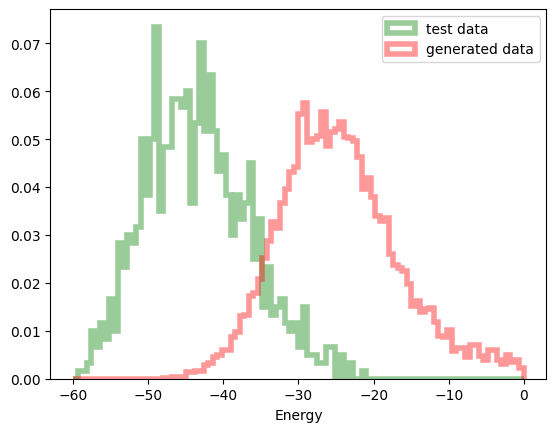

In [58]:
plt.hist(
    test_energy.cpu(),
    bins=100,
    density=True,
    alpha=0.4,
    range=(-60, 0),
    color="g",
    histtype="step",
    linewidth=4,
    label="test data",
)

plt.hist(
    samples_energy.cpu(),
    bins=100,
    density=True,
    alpha=0.4,
    range=(-60, 0),
    color="r",
    histtype="step",
    linewidth=4,
    label="generated data",
)
plt.xlabel("Energy")
plt.legend()

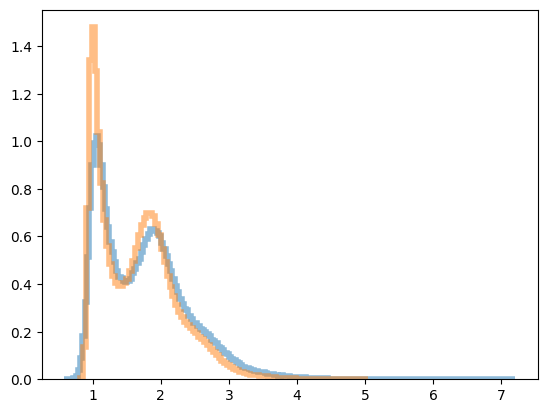

In [382]:
dist_samples = interatomic_dist(samples.reshape(-1, n_nodes, dim))
dist_holdout = interatomic_dist(data_holdout.reshape(-1, n_nodes, dim))
plt.hist(
    dist_samples.view(-1).detach().cpu().numpy(),
    bins=200,
    alpha=0.5,
    density=True,
    histtype="step",
    linewidth=4,
)
plt.hist(
    dist_holdout.view(-1).detach().cpu().numpy(),
    bins=100,
    alpha=0.5,
    density=True,
    histtype="step",
    linewidth=4,
);

### Evaluation

### NLL

In [37]:
follow_estimate = False
follow_model = True
reverse_time = False

In [38]:
def prior_dist(beta):
    dist = torch.distributions.MultivariateNormal(
        torch.zeros(n_nodes * dim).to(device),
        torch.eye(n_nodes * dim).to(device) * beta,
    )
    return dist

In [39]:
def drift(x, t):
    with torch.enable_grad():
        x.requires_grad = True

        if follow_estimate:
            f = estimate_grad_Rt(x, t, noise_schedule, num_mc_samples=100)
            f = clip(f, max_norm=100)
            f = -0.5 * noise_schedule.g(t) ** 2 * f

        else:
            f = vectorfield(t.unsqueeze(-1), x)
            # f = clip(f, max_norm=100)
            f = -0.5 * noise_schedule.g(t)[0] ** 2 * f

    return f

In [40]:
def div_fn(u):
    """Accepts a function u:R^D -> R^D."""
    J = jacrev(u)
    if follow_model:

        def div(x):
            return torch.trace(J(x.unsqueeze(0)).squeeze())

        return div
    else:
        return lambda x: torch.trace(J(x))


def output_and_div(vecfield, x):
    if follow_estimate:
        dx = torch.vmap(vecfield, randomness="different")(x)
    else:
        dx = vecfield(x)

    if reverse_time:
        div = torch.zeros((x.shape[0]), device=device)
    else:
        div = torch.vmap(div_fn(vecfield), randomness="different")(x)
    return dx, div

In [36]:
def odefunc(t, x_in):
    x = x_in[..., :-1].clone().detach().requires_grad_(True)
    t = t.to(device)

    vecfield = lambda x: drift(x, t)
    if follow_model:

        def vecfield(x):
            return drift(x, torch.ones(x.shape[0]).to(device) * t)

    dx, div = output_and_div(vecfield, x)
    div = div.reshape(-1, 1)
    return torch.cat([dx, div], dim=-1)


with torch.no_grad():
    if reverse_time:
        x1 = torch.randn(1024, 39).to(device) * sigma
        time = torch.linspace(1, 0, 1000).to(device)
    else:
        x1 = test_data
        time = torch.linspace(0, 1, 100).to(device)
    state1 = torch.cat([x1, torch.zeros_like(x1[..., :1])], dim=-1)
    state1.requires_grad = True
    state0 = odeint(odefunc, state1, t=time, method="euler")[-1]

    x0, logdetjac = state0[..., :-1], state0[..., -1]
    p0 = prior_dist(beta)
    logp0 = p0.log_prob(x0)
    logp1 = -(logp0 + logdetjac)

NameError: name 'reverse_time' is not defined

In [301]:
print("logp0", logp0.mean())
print("logdetjac", logdetjac.mean())
print("logp1", logp1.mean())

logp0 tensor(-47.5622, device='cuda:0')
logdetjac tensor(-15.4821, device='cuda:0')
logp1 tensor(63.0443, device='cuda:0')


In [302]:
x0_true = torch.randn((1000, n_nodes * dim), device=device) * np.sqrt(beta)
true_logp0 = p0.log_prob(x0_true.view(-1, 39))
print("true_logp0", true_logp0.mean())

true_logp0 tensor(-63.3848, device='cuda:0')


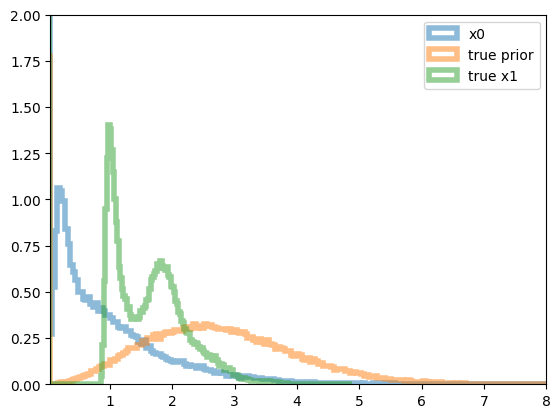

In [303]:
x0 = x0.reshape(-1, n_nodes, dim)
x0_dists = interatomic_dist(x0)
x0_true_dists = interatomic_dist(x0_true.reshape(-1, n_nodes, dim)).detach()
test_dists = interatomic_dist(test_data.reshape(-1, n_nodes, dim))

plt.hist(
    x0_dists.view(-1).detach().cpu().numpy(),
    bins=200,
    alpha=0.5,
    density=True,
    histtype="step",
    linewidth=4,
    label="x0",
)
plt.hist(
    x0_true_dists.view(-1).detach().cpu().numpy(),
    bins=200,
    alpha=0.5,
    density=True,
    histtype="step",
    linewidth=4,
    label="true prior",
)
plt.hist(
    test_dists.view(-1).cpu().numpy(),
    bins=200,
    alpha=0.5,
    density=True,
    histtype="step",
    linewidth=4,
    label="true x1",
)
plt.xlim(0.05, 8)
plt.ylim(0, 2.0)
plt.legend()
plt.show()